In [8]:
# CELDA 1: imports + generación / carga de dataset (guarda en .npz)
import os
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt

# Ruta para guardar el dataset (modificá según convenga)
DATA_PATH = "pendulum_dataset.npz"

def gen_linear_trajectories_from_tf(num_traj=500, t_final=1.0, dt=0.005,
                                    ic_std=(1e-2,1e-2), pulse_prob=0.4, thresh=1e2):
    """Genera trayectorias desde G(s)=1/(s^2-9) en espacio de estados. Devuelve array (N,2)."""
    num = [1.0]
    den = [1.0, 0.0, -9.0]
    sys = signal.TransferFunction(num, den).to_ss()
    t = np.arange(0, t_final+dt, dt)
    all_data = []
    for _ in range(num_traj):
        x0 = np.random.randn(2) * np.array(ic_std)
        if np.random.rand() < pulse_prob:
            u = np.zeros_like(t)
            start = np.random.randint(0, len(t)//2)
            dur = np.random.randint(1, max(2, int(0.05/dt)))
            amp = np.random.randn() * 1.0
            u[start:start+dur] = amp
        else:
            u = np.zeros_like(t)
        try:
            tout, yout, xout = signal.lsim(sys, U=u, T=t, X0=x0)
        except Exception:
            A,B,C,D = sys.A, sys.B, sys.C, sys.D
            x = np.zeros((len(t),2))
            x[0,:] = x0
            for i in range(1,len(t)):
                xdot = A.dot(x[i-1,:]) + B.flatten()*u[i-1]
                x[i,:] = x[i-1,:] + xdot*dt
            xout = x
        all_data.append(xout)
    all_data = np.vstack(all_data)
    mask = np.all(np.abs(all_data) < thresh, axis=1)
    return all_data[mask,:]

def gen_nonlinear_trajectories(num_traj=500, t_final=1.0, dt=0.005, ic_std=(1e-2,1e-2), thresh=1e2):
    """Modelo no lineal: phi'' = (g/l)*sin(phi) + u(t) con g/l=9."""
    g_over_l = 9.0
    t_eval = np.arange(0, t_final+dt, dt)
    all_data = []
    def dyn(t,x,u_func):
        u = u_func(t)
        return np.array([x[1], g_over_l*np.sin(x[0]) + u])
    for _ in range(num_traj):
        x0 = np.random.randn(2) * np.array(ic_std)
        if np.random.rand() < 0.3:
            t0 = np.random.uniform(0, t_final*0.5)
            dur = t_final*0.02
            amp = np.random.randn()*1.0
            u_func = lambda tt, t0=t0, dur=dur, amp=amp: amp if (tt>=t0 and tt<=t0+dur) else 0.0
        else:
            u_func = lambda tt: 0.0
        sol = integrate.solve_ivp(lambda tt,xx: dyn(tt,xx,u_func),
                                  (0,t_final), x0, t_eval=t_eval, method='RK45', max_step=dt)
        if sol.y.shape[1] == len(t_eval):
            all_data.append(sol.y.T)
    all_data = np.vstack(all_data)
    mask = np.all(np.abs(all_data) < thresh, axis=1)
    return all_data[mask,:]

def preprocess(data, zscore=True, clip_thresh=1e2):
    raw = np.asarray(data)
    mask = np.all(np.abs(raw) < clip_thresh, axis=1)
    raw = raw[mask,:]
    mu = raw.mean(axis=0)
    sigma = raw.std(axis=0)
    sigma[sigma==0] = 1.0
    if zscore:
        X = (raw - mu)/sigma
    else:
        X = raw.copy()
    return X, mu, sigma, raw

# ---------- Ejecutar: cargar o generar ----------
if os.path.exists(DATA_PATH):
    print("Cargando dataset existente:", DATA_PATH)
    D = np.load(DATA_PATH)
    raw = D['raw']
    X_norm = D['X_norm']
    mu = D['mu']
    sigma = D['sigma']
    print("raw.shape:", raw.shape, "X_norm.shape:", X_norm.shape)
else:
    print("Generando datos (esto puede tardar algunos segundos)...")
    L = gen_linear_trajectories_from_tf(num_traj=1200, t_final=1.2, dt=0.005,
                                        ic_std=(1e-2,1e-2), pulse_prob=0.5)
    NL = gen_nonlinear_trajectories(num_traj=1200, t_final=1.2, dt=0.005, ic_std=(1e-2,1e-2))
    data_all = np.vstack((L, NL))
    X_norm, mu, sigma, raw = preprocess(data_all, zscore=True, clip_thresh=1e2)
    np.savez(DATA_PATH, raw=raw, X_norm=X_norm, mu=mu, sigma=sigma)
    print("Generado y guardado:", DATA_PATH, "N muestras:", raw.shape[0])

# ahora tienes: raw (Nx2), X_norm (Nx2), mu, sigma


Generando datos (esto puede tardar algunos segundos)...
Generado y guardado: pendulum_dataset.npz N muestras: 578400


In [9]:
# CELDA 2: clase red_kohonen con entrenar mejorado y map_winners vectorizado
import numpy as np

class red_kohonen:
    def __init__(self, n_neuronas_x=10, n_neuronas_y=10,
                 tasa_aprendizaje_inicial=0.1, n_iteraciones=100):
        self.n_neuronas_x = n_neuronas_x
        self.n_neuronas_y = n_neuronas_y
        self.tasa_aprendizaje_inicial = tasa_aprendizaje_inicial
        self.n_iteraciones = n_iteraciones
        self.matriz_neuronas = None
        self.grid_x, self.grid_y = np.meshgrid(
            np.arange(n_neuronas_x),
            np.arange(n_neuronas_y),
            indexing='ij'
        )

    def initialize_neurons(self, data):
        n_x, n_y = self.n_neuronas_x, self.n_neuronas_y
        n_features = data.shape[1]
        self.matriz_neuronas = np.zeros((n_x, n_y, n_features))
        idx = np.random.choice(data.shape[0], size=n_x * n_y, replace=True)
        base = data[idx].reshape(n_x, n_y, n_features)
        ruido = 0.01 * np.random.randn(n_x, n_y, n_features)
        self.matriz_neuronas = base + ruido

    def entrenar(self, data, sigma0=None, sigma_final=0.5,
                sigma_schedule='exp', alpha0=None, alpha_final=0.01,
                alpha_schedule='linear', n_iteraciones=None, snapshot_every=0):
        if n_iteraciones is None:
            n_iteraciones = self.n_iteraciones
        if alpha0 is None:
            alpha0 = self.tasa_aprendizaje_inicial
        if self.matriz_neuronas is None:
            self.initialize_neurons(data)
        n_x, n_y, n_features = self.matriz_neuronas.shape
        N = data.shape[0]
        if sigma0 is None:
            sigma0 = max(n_x, n_y)/2.0
        gx = self.grid_x
        gy = self.grid_y
        snapshots = []
        T = float(n_iteraciones)
        for ep in range(n_iteraciones):
            # alpha schedule
            if alpha_schedule == 'linear':
                alpha = alpha0 + (alpha_final - alpha0) * (ep / (T - 1 + 1e-12))
            else: # exp
                tau_a = max(1.0, -T / (np.log(alpha_final / (alpha0 + 1e-12))))
                alpha = alpha0 * np.exp(-ep / tau_a)
            # sigma schedule
            if sigma_schedule == 'linear':
                sigma = sigma0 + (sigma_final - sigma0) * (ep / (T - 1 + 1e-12))
            else: # exp
                tau_s = max(1.0, -T / (np.log(sigma_final / (sigma0 + 1e-12))))
                sigma = sigma0 * np.exp(-ep / tau_s)
            sigma = max(sigma, 1e-3)
            perm = np.random.permutation(N)
            for idx in perm:
                muestra = data[idx]
                dist = np.linalg.norm(self.matriz_neuronas - muestra, axis=2)
                bx, by = np.unravel_index(np.argmin(dist), dist.shape)
                dx = gx - bx
                dy = gy - by
                dist2 = dx**2 + dy**2
                h = np.exp(-dist2 / (2.0 * sigma**2))
                h_expand = h[..., np.newaxis]
                self.matriz_neuronas += alpha * h_expand * (muestra - self.matriz_neuronas)
            if snapshot_every > 0 and ((ep+1) % snapshot_every == 0):
                snapshots.append(self.matriz_neuronas.copy())
        if snapshot_every > 0:
            return snapshots
        else:
            return None

    def map_winners(self, data, batch=20000):
        W = self.matriz_neuronas
        nx, ny, f = W.shape
        W_flat = W.reshape((nx*ny, f))
        N = data.shape[0]
        winners = np.zeros(N, dtype=int)
        coords = np.zeros((N,2), dtype=int)
        for i0 in range(0, N, batch):
            i1 = min(N, i0+batch)
            Xb = data[i0:i1,:]
            XX = np.sum(Xb**2, axis=1)[:,None]
            WW = np.sum(W_flat**2, axis=1)[None,:]
            XW = Xb.dot(W_flat.T)
            dist_sq = XX + WW - 2*XW
            idx_flat = np.argmin(dist_sq, axis=1)
            winners[i0:i1] = idx_flat
            coords_batch = np.vstack((idx_flat // ny, idx_flat % ny)).T
            coords[i0:i1,:] = coords_batch
        return winners, coords

    def reinit_dead_neurons(self, data, winners, threshold=0):
        nx, ny, f = self.matriz_neuronas.shape
        counts = np.zeros(nx*ny, dtype=int)
        for w in winners:
            counts[w] += 1
        dead = np.where(counts <= threshold)[0]
        if dead.size == 0:
            return 0
        W_flat = self.matriz_neuronas.reshape((nx*ny, f))
        for d in dead:
            W_flat[d,:] = data[np.random.randint(0, data.shape[0])] + 0.01*np.random.randn(f)
        self.matriz_neuronas = W_flat.reshape((nx, ny, f))
        return dead.size


In [ ]:
# CELDA 3: Entrenamiento y métricas (editá parámetros abajo)
import time

# Métricas
def quantization_error(som, X):
    winners, _ = som.map_winners(X)
    W_flat = som.matriz_neuronas.reshape((-1, som.matriz_neuronas.shape[2]))
    d2 = np.sum((X - W_flat[winners])**2, axis=1)
    return np.mean(np.sqrt(d2))

def topographic_error(som, X, batch=20000):
    nx, ny, f = som.matriz_neuronas.shape
    W_flat = som.matriz_neuronas.reshape((nx*ny, f))
    N = X.shape[0]
    not_pres = 0
    total = 0
    for i0 in range(0, N, batch):
        i1 = min(N, i0+batch)
        Xb = X[i0:i1]
        XX = np.sum(Xb**2, axis=1)[:,None]
        WW = np.sum(W_flat**2, axis=1)[None,:]
        XW = Xb.dot(W_flat.T)
        dist_sq = XX + WW - 2*XW
        idx = np.argsort(dist_sq, axis=1)[:, :2]
        for k in range(idx.shape[0]):
            a, b = idx[k]
            ax, ay = a // ny, a % ny
            bx, by = b // ny, b % ny
            total += 1
            if abs(ax-bx) + abs(ay-by) > 1:
                not_pres += 1
    return not_pres / total

def hit_counts_matrix(som, winners):
    nx, ny, _ = som.matriz_neuronas.shape
    counts = np.zeros(nx*ny, dtype=int)
    for w in winners:
        counts[w] += 1
    return counts.reshape((nx, ny))

# -------- parámetros que podés tocar ----------
nx, ny = 20, 20
som_iters = 500
sigma0 = max(nx, ny)/2.0
sigma_final = 0.6
alpha0 = 0.15
alpha_final = 0.01
snapshot_every = 0   # 0 si no querés snapshots

# Cargar datos generados en la Celda 1
# variables disponibles: X_norm (Nx2), raw, mu, sigma
X = X_norm.copy()
raw_data = raw.copy()

# Crear y entrenar
som = red_kohonen(n_neuronas_x=nx, n_neuronas_y=ny,
                  tasa_aprendizaje_inicial=alpha0, n_iteraciones=som_iters)

print("Entrenando SOM: {}x{}, epochs={}".format(nx, ny, som_iters))
t0 = time.time()
snapshots = som.entrenar(X,
                        sigma0=sigma0, sigma_final=sigma_final, sigma_schedule='exp',
                        alpha0=alpha0, alpha_final=alpha_final, alpha_schedule='linear',
                        n_iteraciones=som_iters, snapshot_every=snapshot_every)
print("Tiempo entrenamiento (s):", time.time()-t0)

# Map winners y métricas
winners_flat, winners_coords = som.map_winners(X)
QE = quantization_error(som, X)
TE = topographic_error(som, X)
hits = hit_counts_matrix(som, winners_flat)

print("Quantization error (QE):", QE)
print("Topographic error (TE):", TE)
print("Hits stats: min, median, max =", hits.min(), np.median(hits), hits.max())
dead_neurons = np.sum(hits==0)
print("Neuronas sin hits:", dead_neurons, " / ", nx*ny)

# Guardar pesos si querés
np.savez("som_weights.npz", matriz_neuronas=som.matriz_neuronas, mu=mu, sigma=sigma)
print("Pesos guardados en som_weights.npz")


Entrenando SOM: 15x15, epochs=10
Tiempo entrenamiento (s): 105.02071690559387
Quantization error (QE): 0.026995159583927147
Topographic error (TE): 0.741262102351314
Hits stats: min, median, max = 0 2202.0 9461
Neuronas sin hits: 12  /  225
Pesos guardados en som_weights.npz


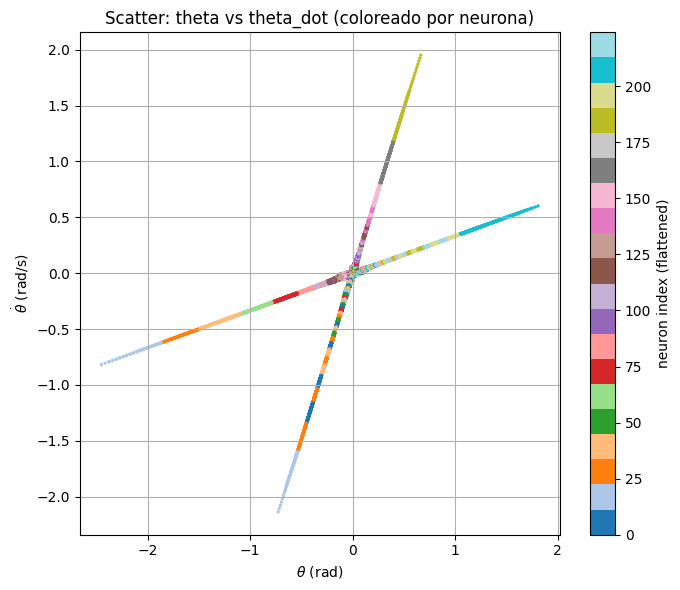

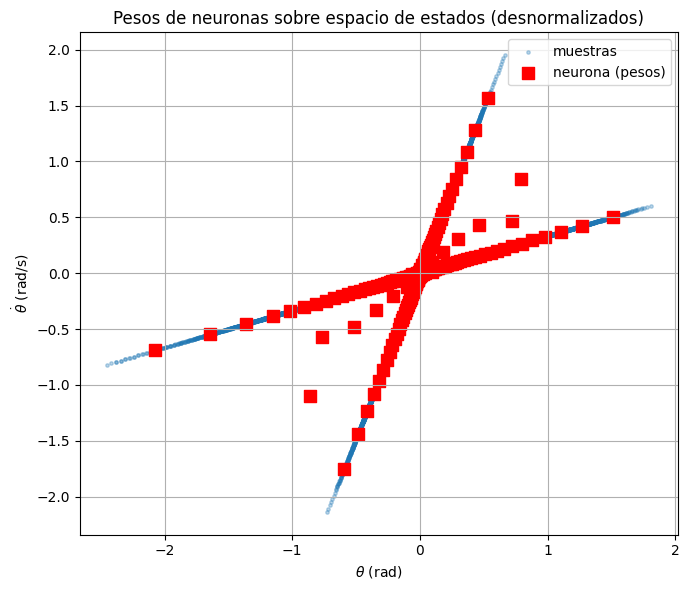

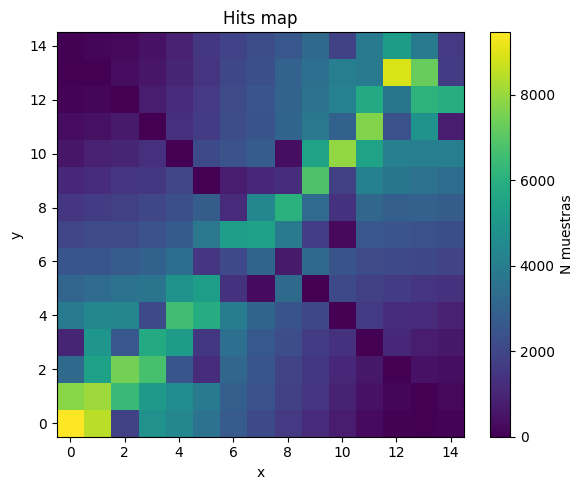

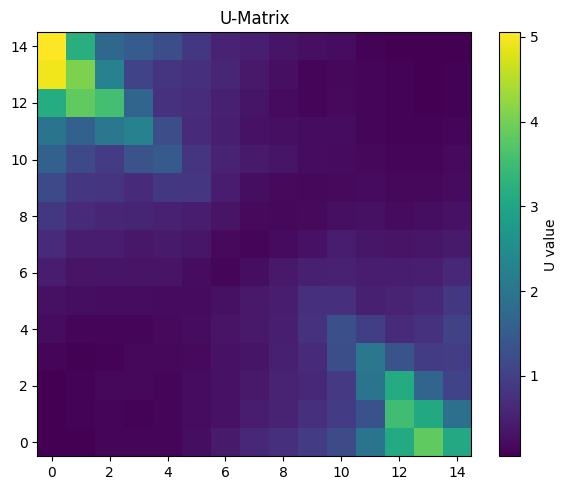

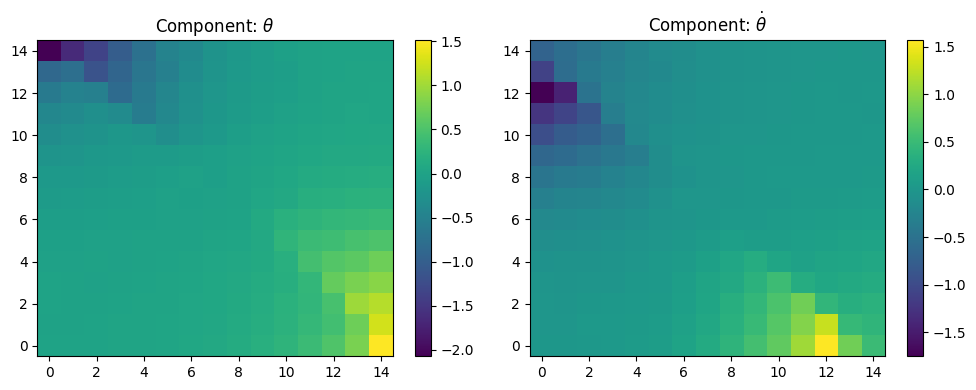

In [13]:
# CELDA 4: plots (scatter por neurona, pesos en espacio, hits, U-matrix, component planes)
import matplotlib.pyplot as plt

def plot_scatter_by_neuron(orig_data, neuron_idx, som, cmap='tab20'):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(orig_data[:,0], orig_data[:,1], c=neuron_idx, s=6, cmap=cmap, linewidths=0)
    plt.xlabel(r'$\theta$ (rad)'); plt.ylabel(r'$\dot\theta$ (rad/s)')
    plt.title('Scatter: theta vs theta_dot (coloreado por neurona)')
    plt.colorbar(sc, label='neuron index (flattened)')
    plt.grid(True); plt.tight_layout()

def plot_neuron_weights_on_state_space(som, mu, sigma, orig_data, show_labels=False):
    W = som.matriz_neuronas.reshape((-1, som.matriz_neuronas.shape[2]))
    W_orig = W * sigma + mu
    plt.figure(figsize=(7,6))
    plt.scatter(orig_data[:,0], orig_data[:,1], s=6, alpha=0.3, label='muestras')
    plt.scatter(W_orig[:,0], W_orig[:,1], marker='s', s=80, c='red', label='neurona (pesos)')
    if show_labels:
        for i in range(W_orig.shape[0]):
            plt.text(W_orig[i,0], W_orig[i,1], str(i), fontsize=8)
    plt.xlabel(r'$\theta$ (rad)'); plt.ylabel(r'$\dot\theta$ (rad/s)')
    plt.title('Pesos de neuronas sobre espacio de estados (desnormalizados)')
    plt.legend(); plt.grid(True); plt.tight_layout()

def plot_hits_map_from_flat(som, winners_flat):
    nx, ny, _ = som.matriz_neuronas.shape
    counts = np.zeros(nx*ny, dtype=int)
    for w in winners_flat:
        counts[w] += 1
    counts = counts.reshape((nx, ny))
    plt.figure(figsize=(6,5))
    plt.imshow(counts.T, origin='lower', interpolation='nearest', aspect='auto')
    plt.colorbar(label='N muestras'); plt.title('Hits map'); plt.xlabel('x'); plt.ylabel('y'); plt.tight_layout()

def compute_u_matrix(som):
    W = som.matriz_neuronas
    nx, ny, f = W.shape
    U = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            neigh = []
            if i>0: neigh.append(W[i-1,j,:])
            if i<nx-1: neigh.append(W[i+1,j,:])
            if j>0: neigh.append(W[i,j-1,:])
            if j<ny-1: neigh.append(W[i,j+1,:])
            if len(neigh)>0:
                neigh = np.vstack(neigh)
                d = np.linalg.norm(neigh - W[i,j,:], axis=1)
                U[i,j] = d.mean()
    return U

def plot_u_matrix(som):
    U = compute_u_matrix(som)
    plt.figure(figsize=(6,5))
    plt.imshow(U.T, origin='lower', interpolation='nearest', aspect='auto')
    plt.colorbar(label='U value'); plt.title('U-Matrix'); plt.tight_layout()

def plot_component_planes(som, mu, sigma, feature_names=None):
    W = som.matriz_neuronas.reshape((-1, som.matriz_neuronas.shape[2]))
    W_orig = W * sigma + mu
    nx, ny, f = som.matriz_neuronas.shape
    if feature_names is None:
        feature_names = [f'feat{i}' for i in range(W_orig.shape[1])]
    plt.figure(figsize=(10,4))
    for k in range(W_orig.shape[1]):
        plt.subplot(1, W_orig.shape[1], k+1)
        plane = W_orig[:,k].reshape((nx, ny)).T
        plt.imshow(plane, origin='lower', interpolation='nearest', aspect='auto')
        plt.colorbar(); plt.title(f'Component: {feature_names[k]}')
    plt.tight_layout()

# Ejecutar las figuras
neuron_idx = winners_flat  # flatten index (0..nx*ny-1)
plot_scatter_by_neuron(raw_data, neuron_idx, som)
plot_neuron_weights_on_state_space(som, mu, sigma, raw_data, show_labels=False)
plot_hits_map_from_flat(som, winners_flat)
plot_u_matrix(som)
plot_component_planes(som, mu, sigma, feature_names=[r'$\theta$', r'$\dot\theta$'])
plt.show()
